# Renormalization Demo

Here is a demonstration of the renormalization-based method for finding an appropriate number of topics.
Several datasets are used for experiments:

* PostNauka
* Brown
* 20 Newsgroups
* Reuters
* WikiRef220
* Good RU Wiki

# Contents<a id="contents"></a>

* [Data](#data)
* [Experiment](#experiment)
* [Plots](#plots)
    * [PostNauka](#postnauka)
    * [Brown](#brown)
    * [Twenty Newsgroups](#twenty-newsgroups)
    * [Reuters](#reuters)
    * [WikiRef220](#wikiref)
    * [Good RU Wiki](#good-ru-wiki)

In [ ]:
# General imports

import json
import numpy as np
import os
import tqdm

from matplotlib import pyplot as plt
from matplotlib import transforms as transforms
from typing import (
    Dict,
    List,
)

%matplotlib inline

Increasing font size in plots

In [ ]:
plt.rcParams['font.size']

10.0

In [ ]:
PLT_FONT_SIZE_DEFAULT = plt.rcParams['font.size']

In [ ]:
PLT_FONT_SIZE_NEW = 20

In [ ]:
plt.rcParams.update({'font.size': PLT_FONT_SIZE_NEW})

In [ ]:
# Making `topnum` module visible for Python

import sys

sys.path.insert(0, '..')

In [ ]:
# Optimal number of topics

from topicnet.cooking_machine import Dataset

from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.model_constructor import KnownModel
from topnum.search_methods import RenormalizationMethod
from topnum.search_methods.renormalization_method import (
    ENTROPY_MERGE_METHOD,
    PHI_RENORMALIZATION_MATRIX,
)

## Data<a id="data"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

We are going to use several datasets here.
Some of them can already be downloaded using TopicNet library.
And some yet not.

More info about TopicNet's datasets one can find here in [demo notebook](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/dataset_manager/DemoDataset.ipynb).
The most up to date picture of what is currently available for download can be obtained like this `topicnet.dataset_manager.get_info()`.

Below we are using the datasets saved locally on disk (so TopicNet's load API `topicnet.dataset_manager.load_dataset(dataset_name)` is not used).

In this folder all datasets reside

In [ ]:
DATASETS_FOLDER_PATH = '/data/datasets'

Let's see, what datasets we have locally

In [ ]:
os.listdir(DATASETS_FOLDER_PATH)

['MKB10_wiki',
 '20_News_dataset',
 'VkusVill',
 'Reddit',
 'Habrahabr',
 'RTL_WIKI',
 'README.md',
 'lenta',
 'postnauka',
 'Reuters',
 'Khaleej2004',
 'TechCrunch',
 'Sber_data',
 'Sogou_News',
 'NIPS',
 'AG_News',
 'Search_dataset(byweb2007)',
 'ruwiki_good',
 '_tmp_alexeev',
 'Triplets_dataset',
 'Brown',
 'Watan2004',
 'RuRebus_no_labels',
 'WikiRef220',
 '10k_German_News']

Datasets we are going to use (these are just ID's to be used in the notebook further, not folder names):

In [ ]:
DATASET_NAME_POSTNAUKA         = 'PostNauka'
DATASET_NAME_BROWN             = 'Brown'
DATASET_NAME_TWENTY_NEWSGROUPS = '20NG'
DATASET_NAME_REUTERS           = 'Reuters'
DATASET_NAME_WIKIREF           = 'WikiRef220'
DATASET_NAME_GOOD_RU_WIKI      = 'GoodRuWiki'

In a couple of cells below we select a dataset to work with (by defining some path variables).

In [ ]:
DATASET_FOLDER_NAME = 'WikiRef220'      # and this is the name of a folder on disk

DATASET_FOLDER_PATH = os.path.join(
    DATASETS_FOLDER_PATH, DATASET_FOLDER_NAME
)

In [ ]:
os.listdir(DATASET_FOLDER_PATH)

['WikiRef220_preprocessing.ipynb', 'wiki_ref220_vw.txt']

In [ ]:
DATASET_FILE_NAME = 'wiki_ref220_vw.txt'  # name of a file on disk
DATASET_NAME = DATASET_NAME_WIKIREF       # one of the DATASET_NAME's
                                          # corresponding to the dataset file

DATASET_FILE_PATH = os.path.join(
    DATASET_FOLDER_PATH, DATASET_FILE_NAME
)

DATASET_INTERNALS_FOLDER_NAME_SUFFIX = '__internals__renormalization'
DATASET_INTERNALS_FOLDER_PATH = os.path.join(
    '.',
    DATASET_NAME + DATASET_INTERNALS_FOLDER_NAME_SUFFIX
)

In [ ]:
DATASET_INTERNALS_FOLDER_PATH  # here we are also going to save search results

'./WikiRef220__internals__renormalization'

In [ ]:
! ls $DATASET_INTERNALS_FOLDER_PATH

batches				      threshold2result__LDA.json
dict.dict			      threshold2result__PLSA.json
threshold2result__ARTM.json	      threshold2result__sparse.json
threshold2result__decorrelation.json  vw.txt


Checking if all OK with data, what modalities does the collection have.

In [ ]:
! head -n 1 $DATASET_FILE_PATH

smartphone.107 |@lemmatized secret:1 behind:2 poor:1 smartphone:12 battery:22 life:13 summary:1 shiny:2 new:7 easily:2 last:6 day:10 go:4 downhill:1 rapidly:1 deteriorate:2 long:4 tolerate:1 owner:5 mainly:1 choice:1 phone:9 usually:1 meet:2 holy:1 grail:1 ability:1 first:1 start:4 get:5 worse:1 quickly:1 many:3 end:2 plug:1 seem:1 always:2 way:2 incentive:5 maker:3 make:3 good:5 focus:1 mobile:5 segment:1 early:1 possible:1 time:2 away:2 power:1 outlet:1 prompt:1 oems:2 could:1 device:4 longer:1 decent:1 laptop:4 tablet:9 eight:1 hour:3 need:2 matter:1 come:2 except:1 pick:1 top:2 rank:1 talk:1 one:4 odds:1 hear:2 familiar:1 tale:1 year:3 probably:1 antic:1 daily:1 still:2 work:1 see:2 related:1 fall:2 sale:1 problem:1 necessary:1 improve:3 like:1 believe:2 reason:2 obvious:1 fact:1 keep:1 thing:1 recent:1 article:2 explain:1 upgrading:1 current:1 enough:3 compelling:1 late:2 great:1 big:1 part:1 satisfaction:1 everyone:1 even:1 result:1 shorter:1 give:1 smartphones:1 different:1 stor

We are using Vowpal Wabbit files in Bag of Words format here, because order of words doesn't matter (which is not the case for Intratext Coherence scores, for example).

Number of documents:

In [ ]:
! wc -l $DATASET_FILE_PATH

220 /data/datasets/WikiRef220/wiki_ref220_vw.txt


Defining a text collection entity, which is to be passed to topic number search method later:

In [ ]:
DATASET = Dataset(
    data_path             = DATASET_FILE_PATH,
    internals_folder_path = DATASET_INTERNALS_FOLDER_PATH,
)

Double-checking if all OK with file paths:

In [ ]:
DATASET._data_path

'/data/datasets/WikiRef220/wiki_ref220_vw.txt'

In [ ]:
DATASET._internals_folder_path

'./WikiRef220__internals__renormalization'

In [ ]:
DATASET._data.shape  # yet another way to see the number of documents

(220, 3)

In [ ]:
DATASET._modalities

{'@lemmatized', '@ngramms'}

Let's shrink dataset dictionary (for faster computing and lighter memory usage)

In [ ]:
dictionary = DATASET.get_dictionary()

In [ ]:
dictionary

artm.Dictionary(name=5350a211-12d0-418f-a23c-1b314d18a711, num_entries=14476)

Seems reasonable to try filter in a way to keep just several thousand words.
The main parameter is `min_df_rate`.

In [ ]:
dictionary.filter(min_df_rate=0.02, max_df_rate=0.5)

artm.Dictionary(name=5350a211-12d0-418f-a23c-1b314d18a711, num_entries=2792)

Saving the filtered dictionary as cashed dictionary for dataset (if not do so, the filtering will have no effect, as dataset's dictionary will stay unchanged).

In [ ]:
DATASET._cached_dict = dictionary

In [ ]:
DATASET.get_dictionary()

artm.Dictionary(name=5350a211-12d0-418f-a23c-1b314d18a711, num_entries=2792)

In [ ]:
TEXT_COLLECTION = VowpalWabbitTextCollection.from_dataset(
    DATASET,
    main_modality='@lemmatized',  # one of the `DATASET._modalities`!
)

## Experiment<a id="experiment"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

And here is the searching process itself.
The search method has several parameters: some are specific for the renormalization approach, some are common for all the search methods presented in `topnum` module.

We are going to fulfill the search for several model families to see if renormalization depends on the model family or not.
If it does, it will be somewhat strange: it would mean that the optimal number of topics in a dataset depends on what models one trains on this dataset.

We are going to also vary one parameter of Renormalization method.
Namely `threshold factor`: in the papers that are referenced in the README the threshold was set equal to `1`.
However, this is not clear why it was fixed.
Seems interesting to vary it and see what happens.

In [ ]:
THRESHOLD_FACTORS = [1.0, 2.0, 10.0]

In [ ]:
DATASET_INTERNALS_FOLDER_PATH

'./WikiRef220__internals__renormalization'

In [ ]:
%%time

MAX_NUM_TOPICS     = 100  # number of topics in one model
NUM_FIT_ITERATIONS = 100  # 100 or 200 surely should be enough
                          # however, for big datasets (like Good RU Wiki)
                          # better to decrease this one (to 10 iterations, for example)
NUM_RESTARTS       = 3    # number of models for averaging

for model_family in [
        KnownModel.PLSA,
        KnownModel.LDA,
        KnownModel.SPARSE,
        KnownModel.DECORRELATION,
        KnownModel.ARTM]:

    threshold2result = dict()

    for threshold in tqdm.tqdm(
            THRESHOLD_FACTORS, total=len(THRESHOLD_FACTORS), file=sys.stdout):

        optimizer = RenormalizationMethod(
            merge_method               = ENTROPY_MERGE_METHOD,
            matrix_for_renormalization = PHI_RENORMALIZATION_MATRIX,
            model_family               = model_family,
            threshold_factor           = threshold,
            max_num_topics             = MAX_NUM_TOPICS,
            num_fit_iterations         = NUM_FIT_ITERATIONS,
            num_restarts               = NUM_RESTARTS,
        )

        optimizer.search_for_optimum(TEXT_COLLECTION)

        # The search method's result may be accessed as optimizer._result
        threshold2result[threshold] = optimizer._result

    result_file_path = os.path.join(
        DATASET_INTERNALS_FOLDER_PATH,
        f'threshold2result__{model_family.value}.json',
    )

    with open(result_file_path, 'w') as f:
        f.write(json.dumps(threshold2result))

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/99 [00:00<?, ?it/s]


  9%|▉         | 9/99 [00:02<00:26,  3.36it/s]


 18%|█▊        | 18/99 [00:05<00:24,  3.33it/s]


 27%|██▋       | 27/99 [00:07<00:21,  3.40it/s]


 36%|███▋      | 36/99 [00:10<00:17,  3.56it/s]


 45%|████▌     | 45/99 [00:12<00:14,  3.81it/s]


 55%|█████▍    | 54/99 [00:13<00:10,  4.16it/s]


 64%|██████▎   | 63/99 [00:15<00:07,  4.65it/s]


 73%|███████▎  | 72/99 [00:16<00:05,  5.34it/s]


 82%|████████▏ | 81/99 [00:17<00:02,  6.31it/s]


 91%|█████████ | 90/99 [00:17<00:01,  7.78it/s]


100%|██████████| 99/99 [00:17<00:00,  5.50it/s]

 33%|███▎      | 1/3 [00:41<01:23, 41.58s/it]


............................................

100%|██████████| 3/3 [08:01<00:00, 160.46s/it]


...........other model families.............

CPU times: user 35min 51s, sys: 20.1 s, total: 36min 11s
Wall time: 35min 44s


In [ ]:
assert len(threshold2result) == len(THRESHOLD_FACTORS)

print(len(threshold2result))

3


Let's see what is available as result for some `threshold`:

In [ ]:
list(next(iter(threshold2result.values())).keys())

['optimum',
 'optimum_std',
 'renyi_entropy_values',
 'energy_values',
 'snannon_entropy_values',
 'num_topics_values',
 'renyi_entropy_values_std',
 'energy_values_std',
 'snannon_entropy_values_std',
 'num_topics_values_std']

Point estimate of the number of topics and standard deviation (std) over the restarts (`num_restarts`) for one `threshold`:

In [ ]:
threshold_sample = list(threshold2result.keys())[0]
result_sample = threshold2result[threshold_sample]

optimum = result_sample['optimum']
optimum_std = result_sample['optimum_std']

print(
    f'Threshold factor: {threshold}'
)
print(
    f'Optimum: {optimum} topics.' +
    f' Std: {optimum_std}'
)

Threshold factor: 10.0
Optimum: 37.0 topics. Std: 0.0


## Plots<a id="plots"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

There are also some metrics calculated for each model.
Let us look at `renyi_entropy_values`: by assumption which were made in the papers referenced in the [README](https://github.com/machine-intelligence-laboratory/OptimalNumberOfTopics/tree/master) of the repository, the lower the entropy, the more stable the model.
Thus, looking at entropy values for different number of topics, one may find the best such number, which makes the model the most stable.

Let's make a function to plot the dependence of entropy on the number of topics.

In [ ]:
RESULT_KEY_NUMBER_OF_TOPICS = 'num_topics_values'
RESULT_KEY_METRIC           = 'renyi_entropy_values'
RESULT_KEY_METRIC_STD       = 'renyi_entropy_values_std'

In [ ]:
NUM_TOPICS_MAJOR_TICKS = range(0, MAX_NUM_TOPICS + 1, 10)
NUM_TOPICS_MINOR_TICKS = range(0, MAX_NUM_TOPICS + 1, 5)

In [ ]:
RESULTS_TYPE = Dict[float, Dict[str, List[float]]]

In [ ]:
def draw_plot(dataset_results: RESULTS_TYPE) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    additional_xticks = list()
    sorted_thresholds = sorted(dataset_results.keys(), key=lambda k: float(k))
    
    shift = None
    x_opts = list()

    for threshold, color in zip(
            sorted_thresholds,
            [(18.0/255, 47.0/255, 170.0/255), (255.0/255, 153.0/255, 0.0), 'g']):

        result = dataset_results[threshold]

        x = result[RESULT_KEY_NUMBER_OF_TOPICS]
        y = result[RESULT_KEY_METRIC]

        ax.errorbar(
            x=x,
            y=y,
            yerr=result[RESULT_KEY_METRIC_STD],
            linestyle='None',
            marker='o',
            color=color,
            markersize=10,
            capsize=5,
            label=f'threshold = $1/|W| * {int(float(threshold)):2}$'
        )
    
        if shift is None:  # one shift for all thresholds
            shift = sorted_thresholds.index(threshold) * 0.05
        
        # So as to make the optimal number visible

        x_opt = int(x[np.argmin(y)])
        vline_ymax = 0.7 + shift
        additional_xticks.append(x_opt)

        ax.axvline(
            x_opt,
            ymin=0.02,
            ymax=vline_ymax,
            lw=2,
            color=color,
            linestyle='--',
        )
        
        # About transform:
        # https://stackoverflow.com/questions/13413112/creating-labels-where-line-appears-in-matplotlib-figure
        
        transform = transforms.blended_transform_factory(
            ax.transData, ax.transAxes
        )

        # If two optimum numbers are too close — texts overlay
        # so in this case text will be visible only for one point
        if all(abs(_ - x_opt) >= 2 for _ in x_opts):
            ax.text(
                x_opt,
                vline_ymax + 0.01,
                fr'$x^* = {x_opt}$',
                transform=transform,
                fontdict={'size': PLT_FONT_SIZE_NEW - 6},
                rotation=45,
            )

        x_opts.append(x_opt)

        ax.set_xlabel('Number of topics')
        ax.set_ylabel('Rényi entropy')
        
        # About ticks:
        # https://stackoverflow.com/questions/24943991/change-grid-interval-and-specify-tick-labels-in-matplotlib
        
        ax.set_xticks(NUM_TOPICS_MAJOR_TICKS)
        ax.set_xticks(NUM_TOPICS_MINOR_TICKS, minor=True)

        ax.grid(which='minor', alpha=0.5)
        ax.grid(which='major', alpha=1)

        ax.legend()

    # `additional_xticks` is legacy: not used in the current version of the notebook
    
    return ax, additional_xticks

In [ ]:
def load_result(dataset_name: str, model_family: KnownModel) -> RESULTS_TYPE:
    dataset_internals_folder_path = os.path.join(
        '.',
        dataset_name + DATASET_INTERNALS_FOLDER_NAME_SUFFIX
    )
    result_file_path = os.path.join(
        dataset_internals_folder_path,
        f'threshold2result__{model_family.value}.json'
    )

    return json.loads(
        open(result_file_path, 'r').read()
    )

Padding makes it possible to cut off the titles when inserting an image somewhere in text.

In [ ]:
DEFAULT_Y_MAX     = 7   # to cut off too far points
DEFAULT_TITLE_PAD = 25  # to separate the title from the plot

In [ ]:
def draw_all_plots(dataset_name: str) -> None:
    for model_family in KnownModel:
        ax, _ = draw_plot(
            load_result(
                dataset_name=dataset_name,
                model_family=model_family,
            )
        )

        ax.set_ylim(ymax=DEFAULT_Y_MAX)
        ax.set_title(f'{model_family.name}', pad=DEFAULT_TITLE_PAD)

    plt.show()

Below go plots for the selected datasets (previous cells were run several times: for each dataset)

### PostNauka<a id="postnauka"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Test plot:

In [ ]:
threshold2result = load_result(DATASET_NAME_POSTNAUKA, KnownModel.PLSA)

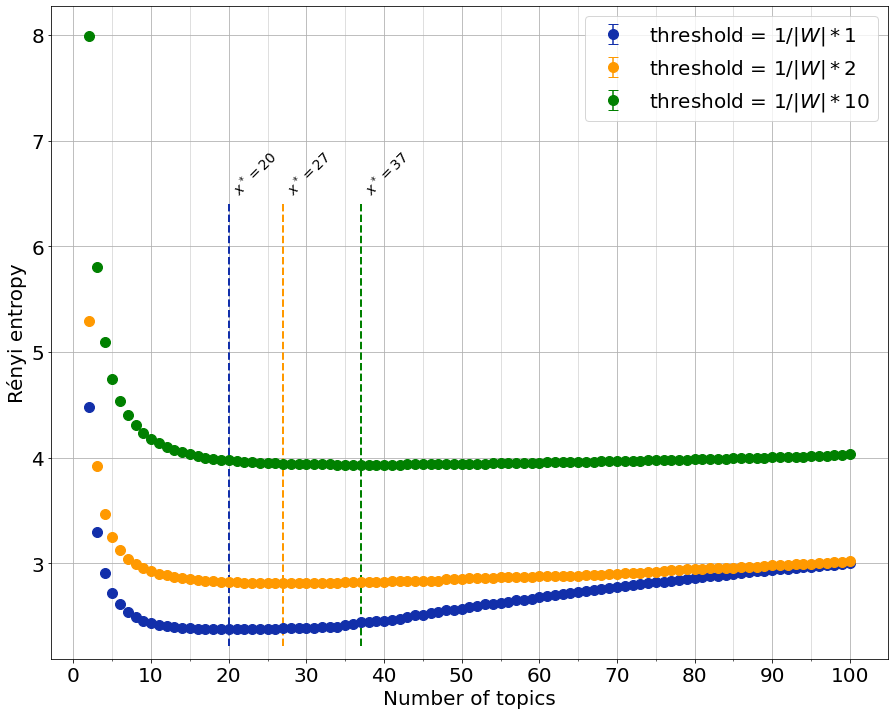

In [ ]:
ax, additional_xticks = draw_plot(threshold2result)

# Not used anymore: now there is text instead of additional ticks
#
# xlim = ax.get_xlim()
# ax.set_xticks(list(ax.get_xticks()) + additional_xticks[1:2])
# ax.set_xticks(NUMBER_OF_TOPICS_TICKS)
# ax.set_xlim(xlim)

plt.show()

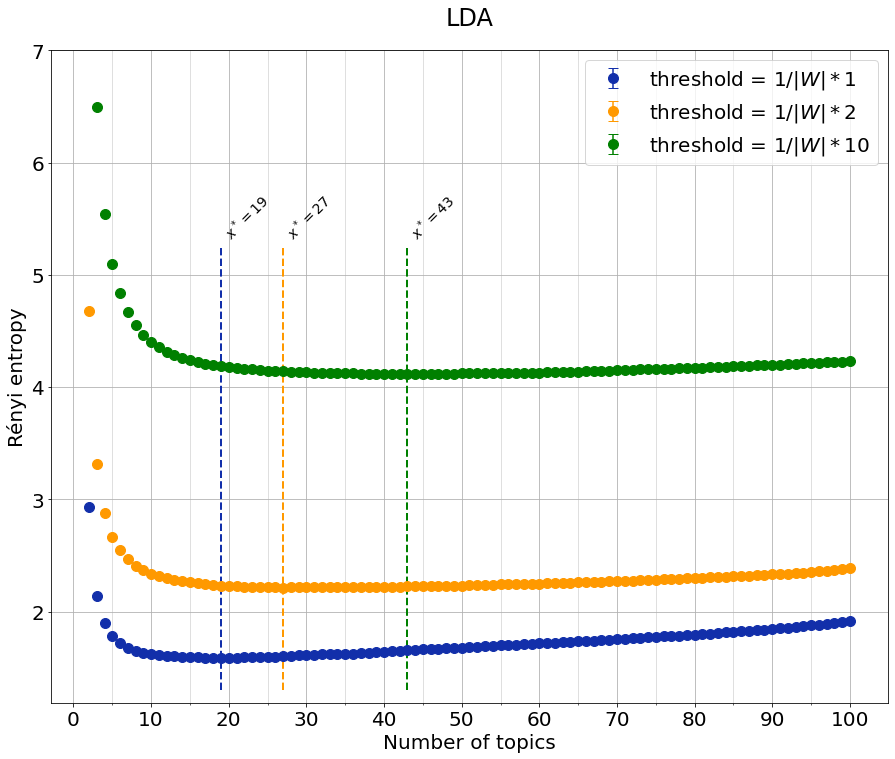

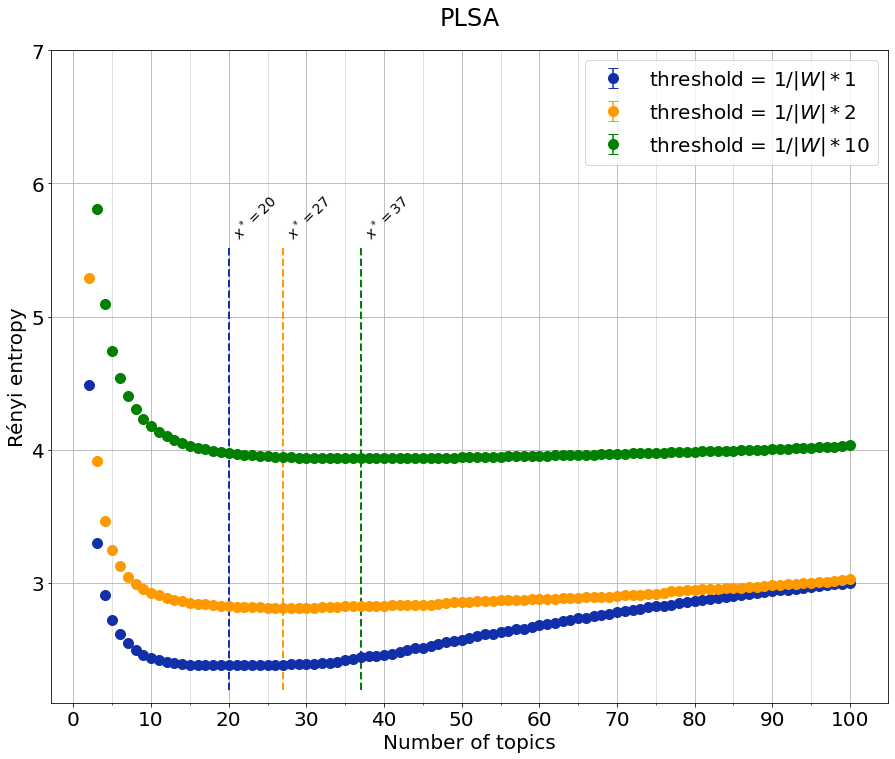

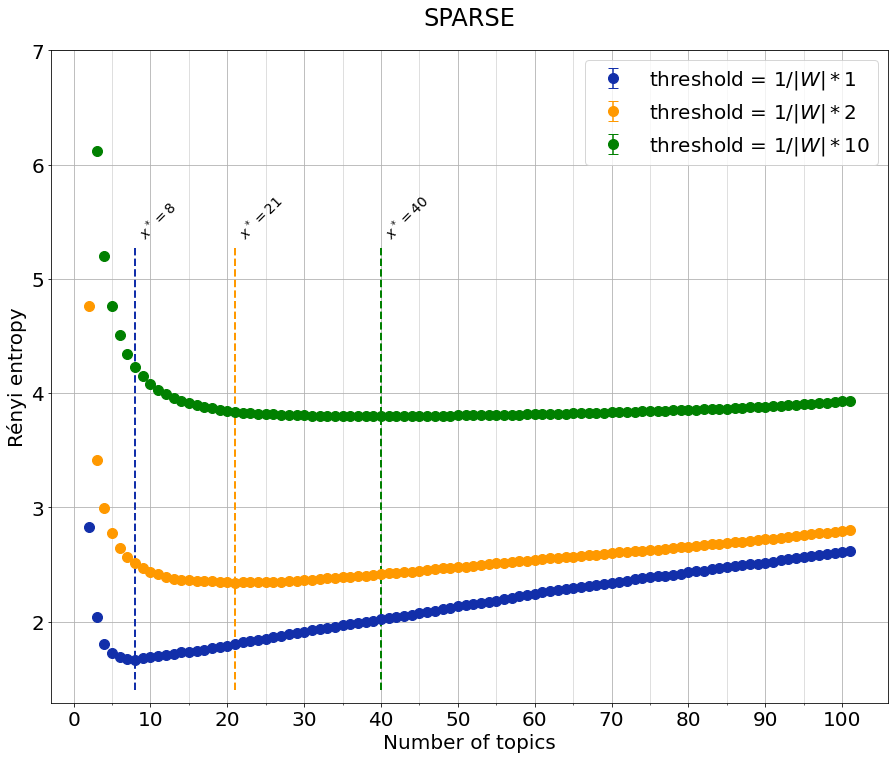

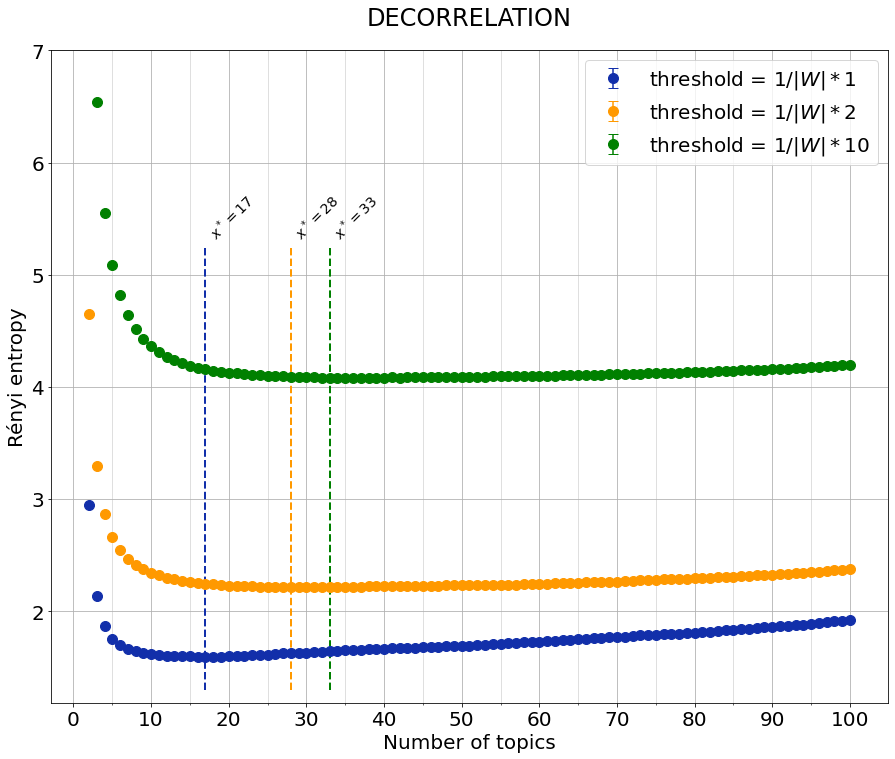

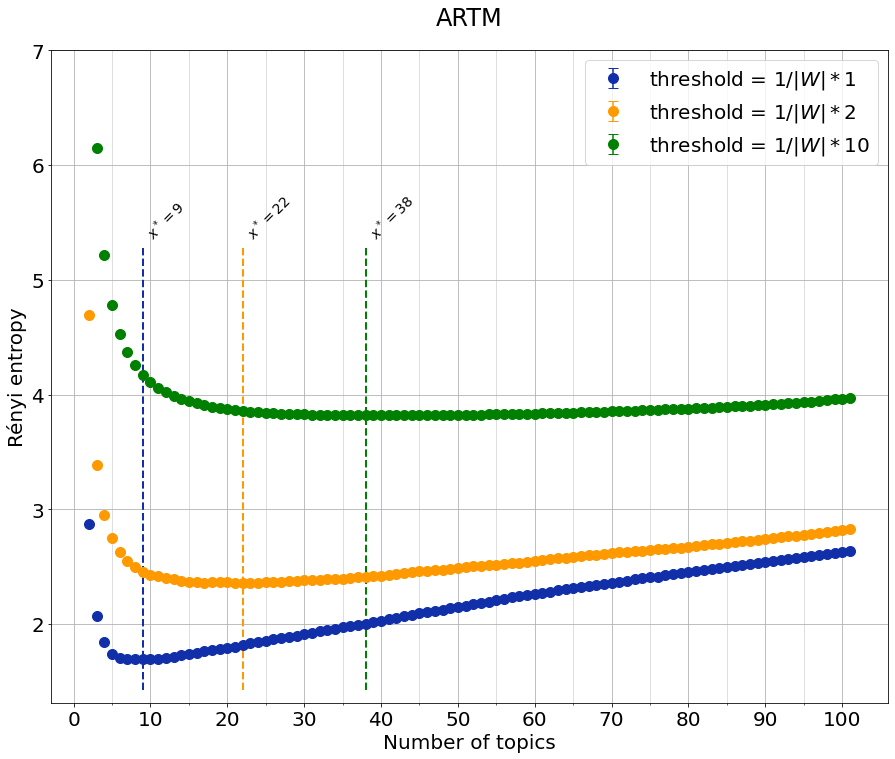

In [ ]:
draw_all_plots(DATASET_NAME_POSTNAUKA)

`PLSA` and `LDA` succeded (`threshold = 1`).
`SPARSE` and `ARTM` failed (nearly $10$ topics instead of $19$).
However, the collection is unbalanced.

### Brown<a id="brown"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

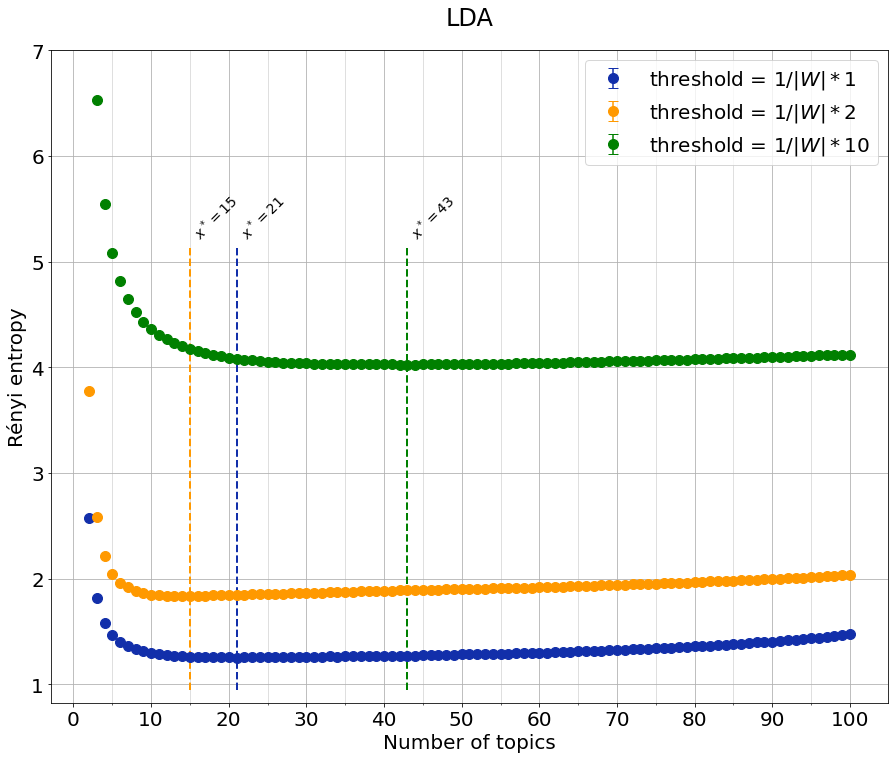

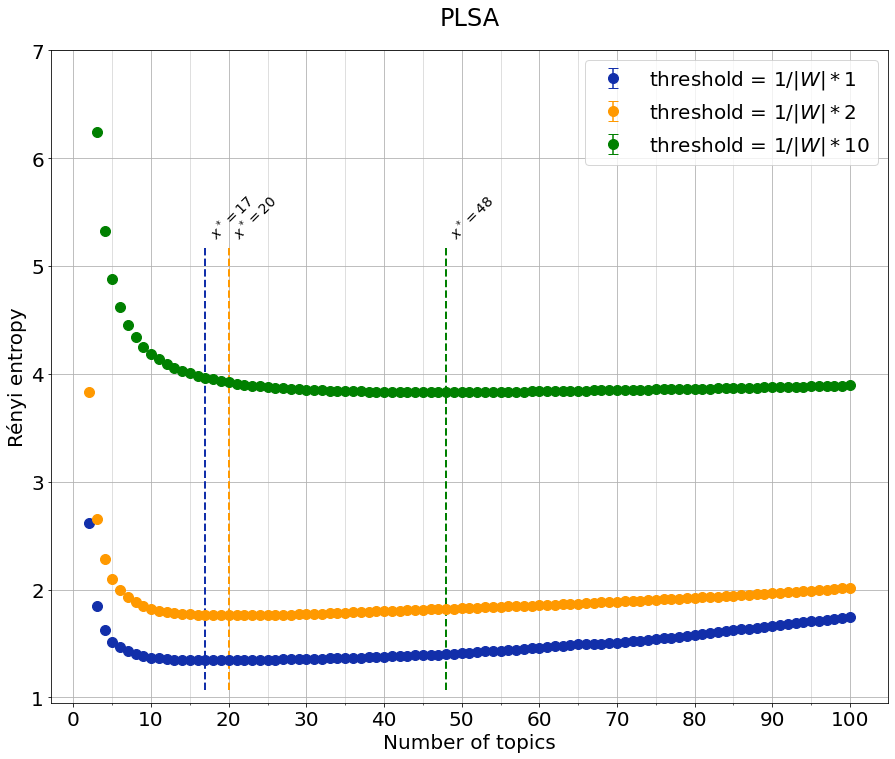

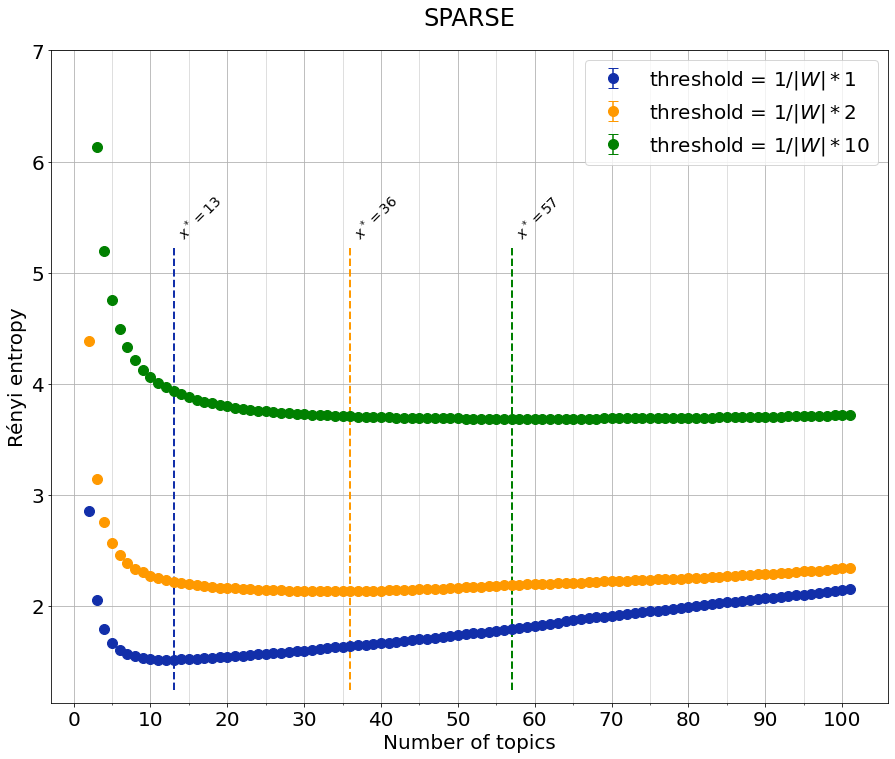

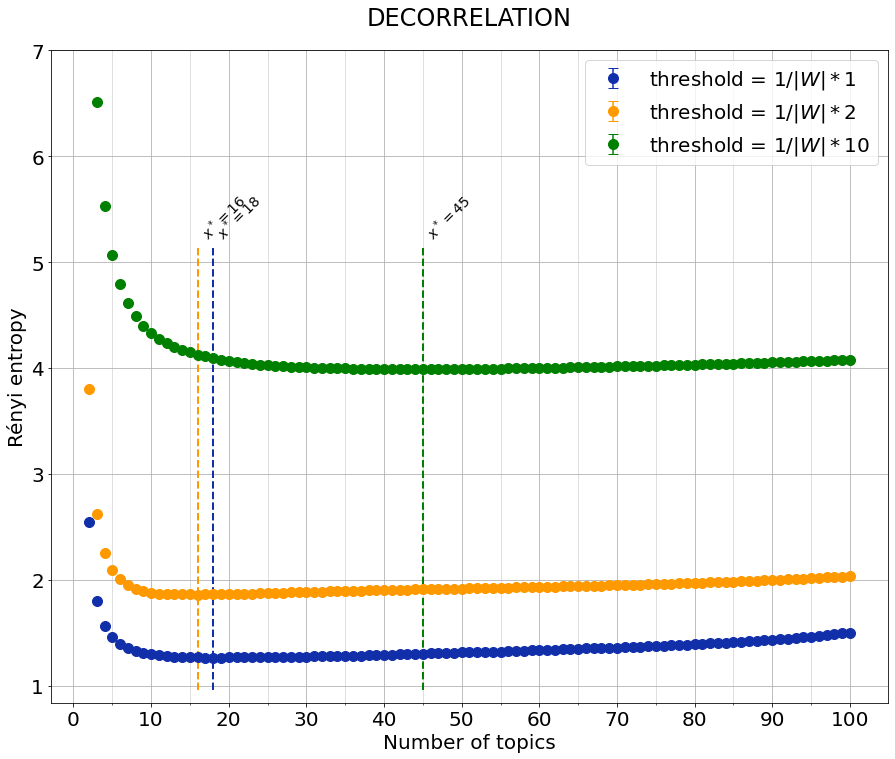

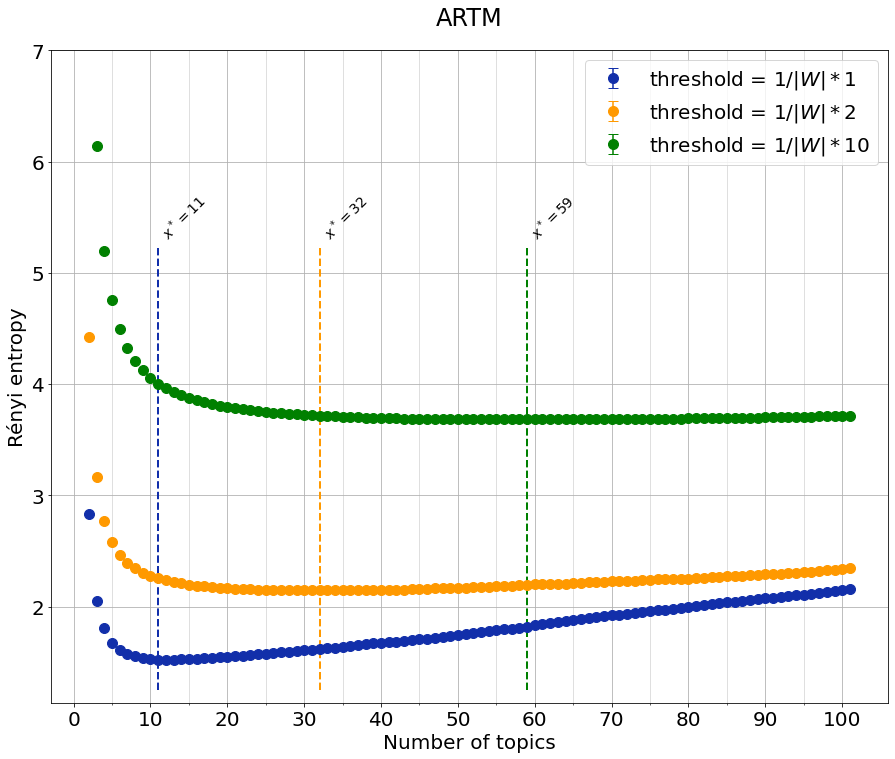

In [ ]:
draw_all_plots(DATASET_NAME_BROWN)

`SPARSE` and `ARTM`, again, showed fewer topics, than other models (taking into account only `threshold = 1`; for other thresholds the situation is the opposite...).
`PLSA` and `DECORRELATION` were better here ($17$ and $18$ topics respectively instead of expected $15$).

### Twenty Newsgroups<a id="twenty-newsgroups"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

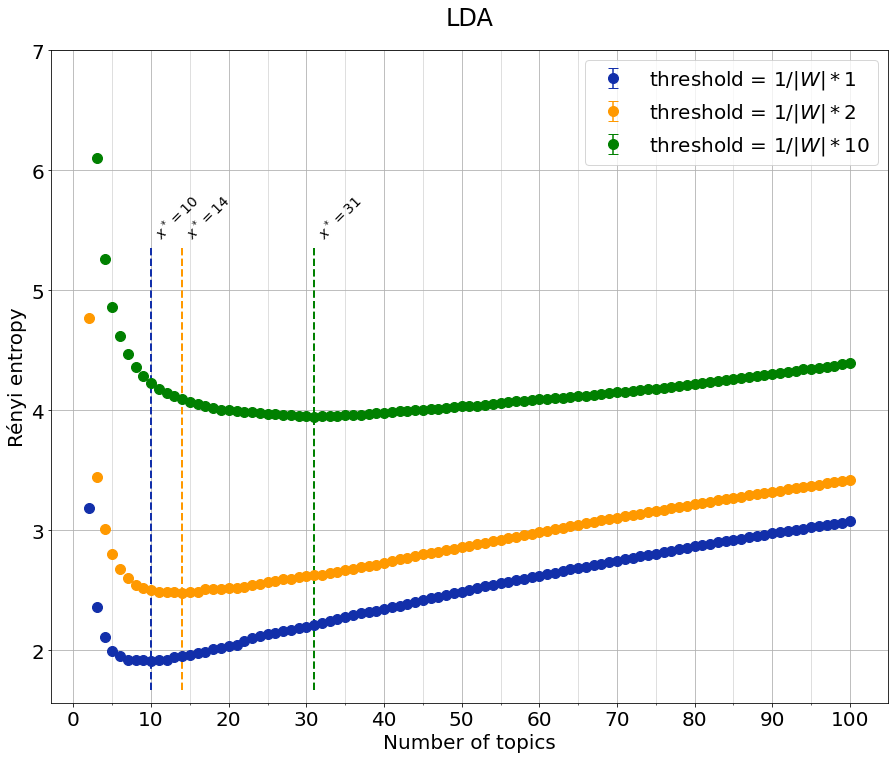

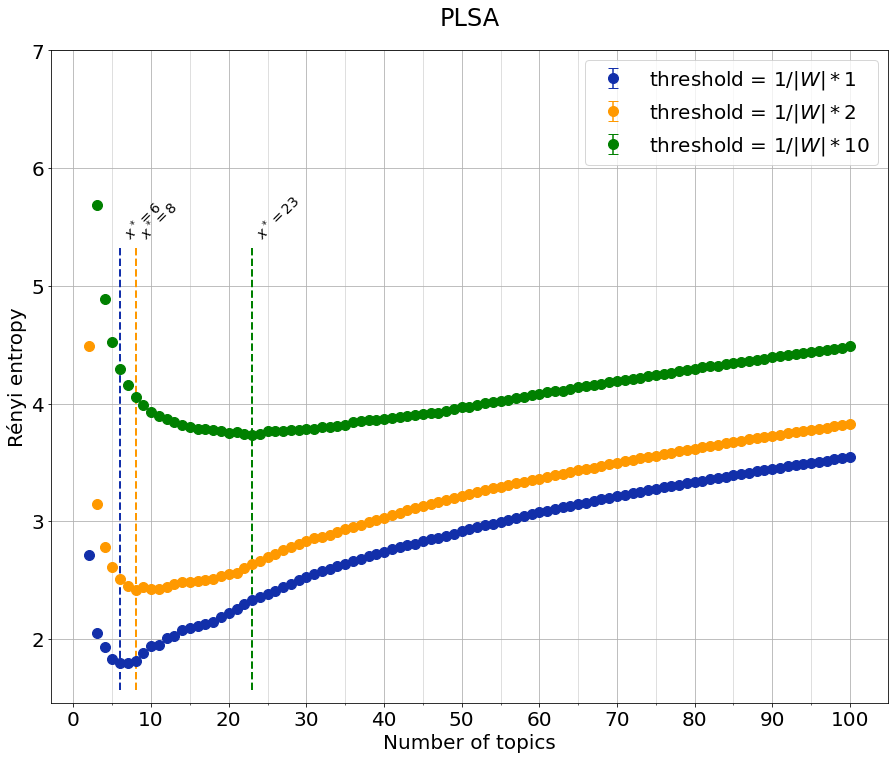

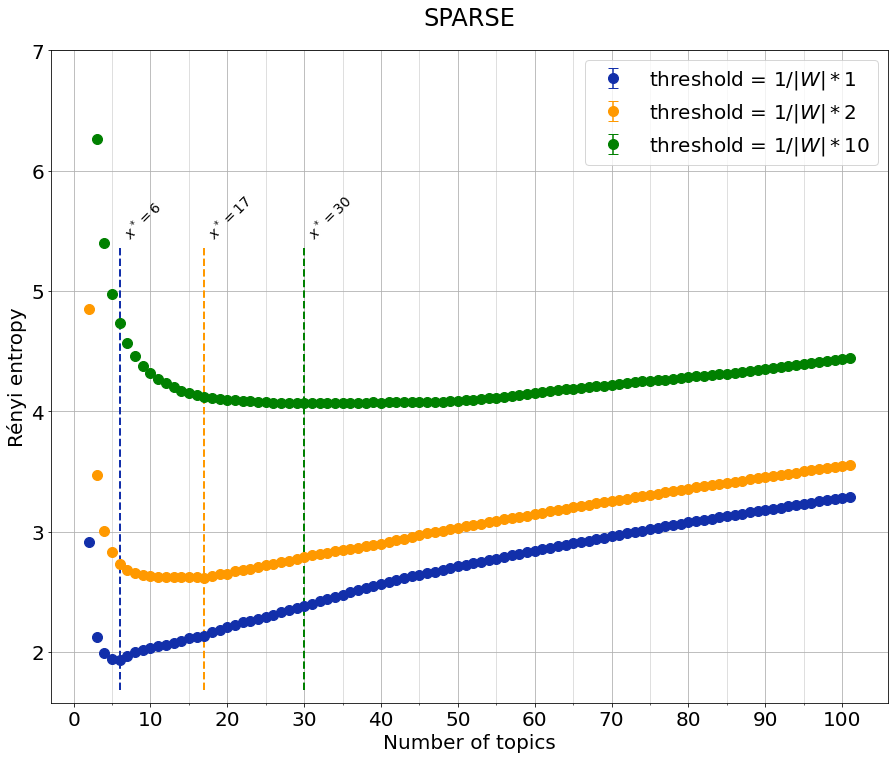

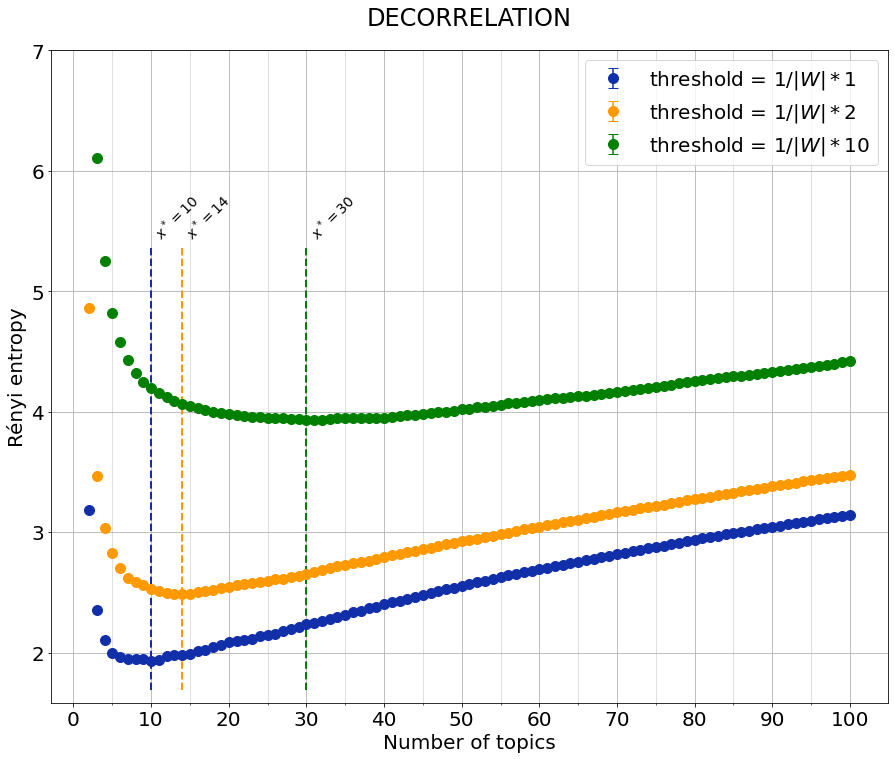

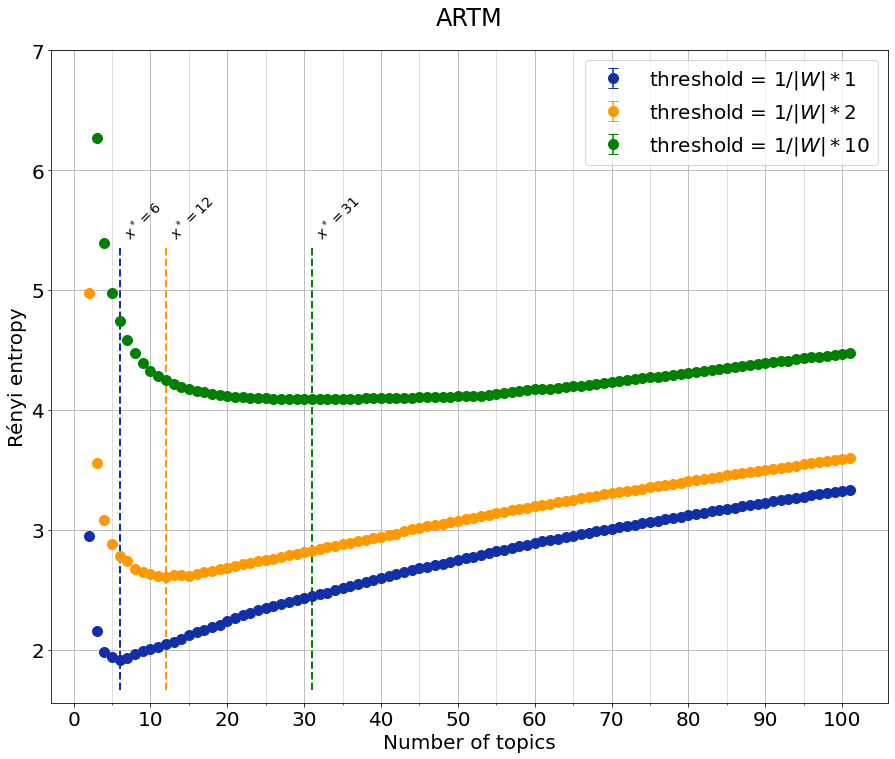

In [ ]:
draw_all_plots(DATASET_NAME_TWENTY_NEWSGROUPS)

There are $20$ topics in the dataset.
However, some of them are quite similar (`rec.sport.baseball` vs. `rec.sport.hockey`).
So numbers of topics from $7$ (number of top categories: `alt`, `comp`, `misc`, `rec`, `sci`, `soc`, `talk`) to $20$ may be considered successful.
All models (considering only `threshold = 1`) managed to find an optimal number of topics.

### Reuters<a id="reuters"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

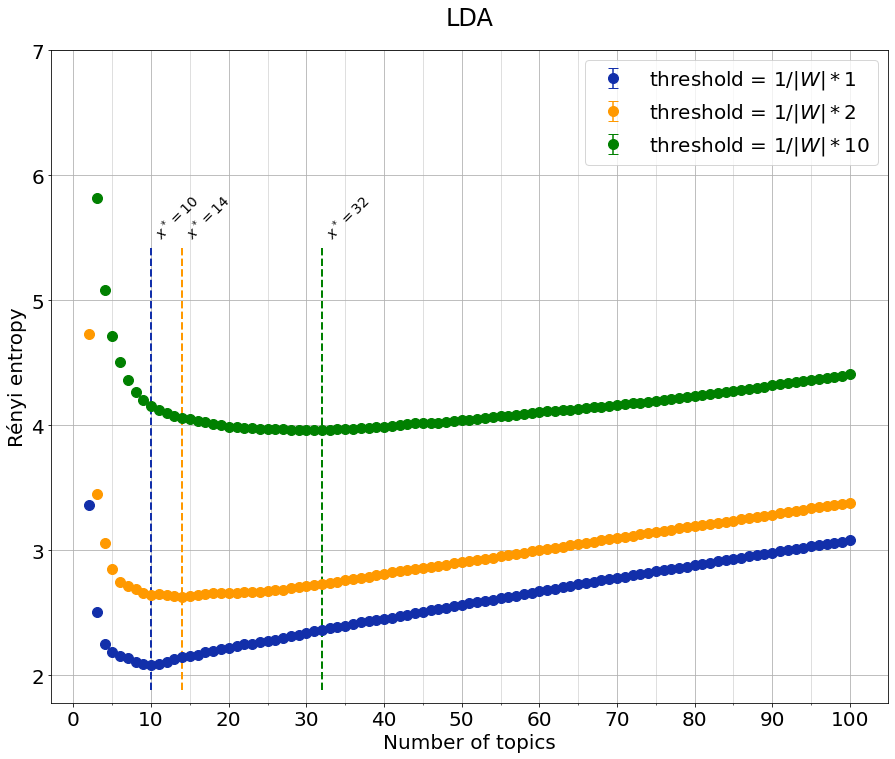

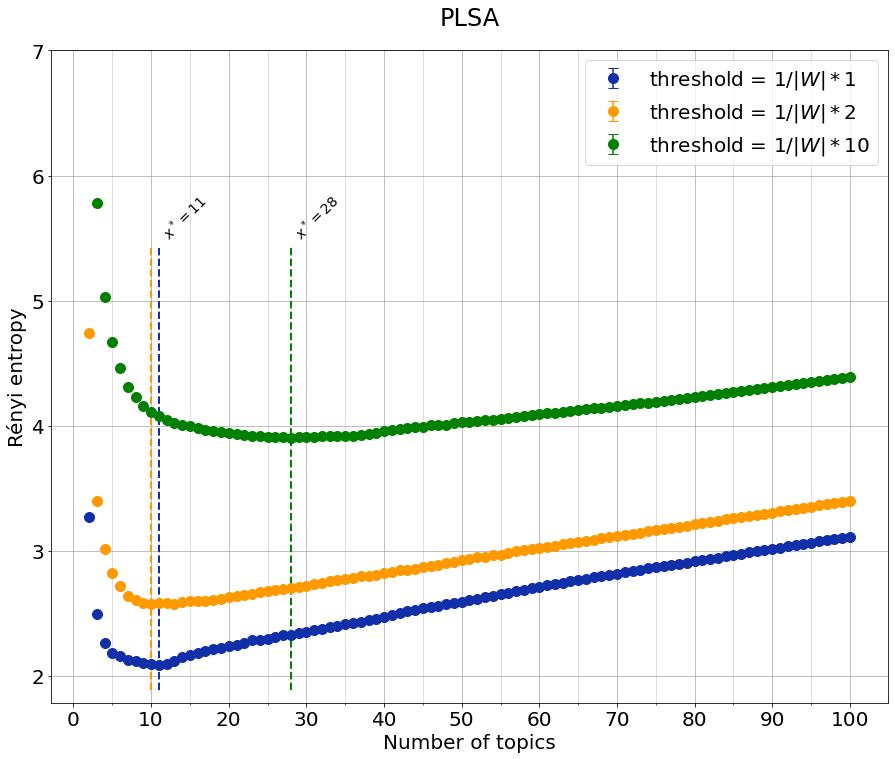

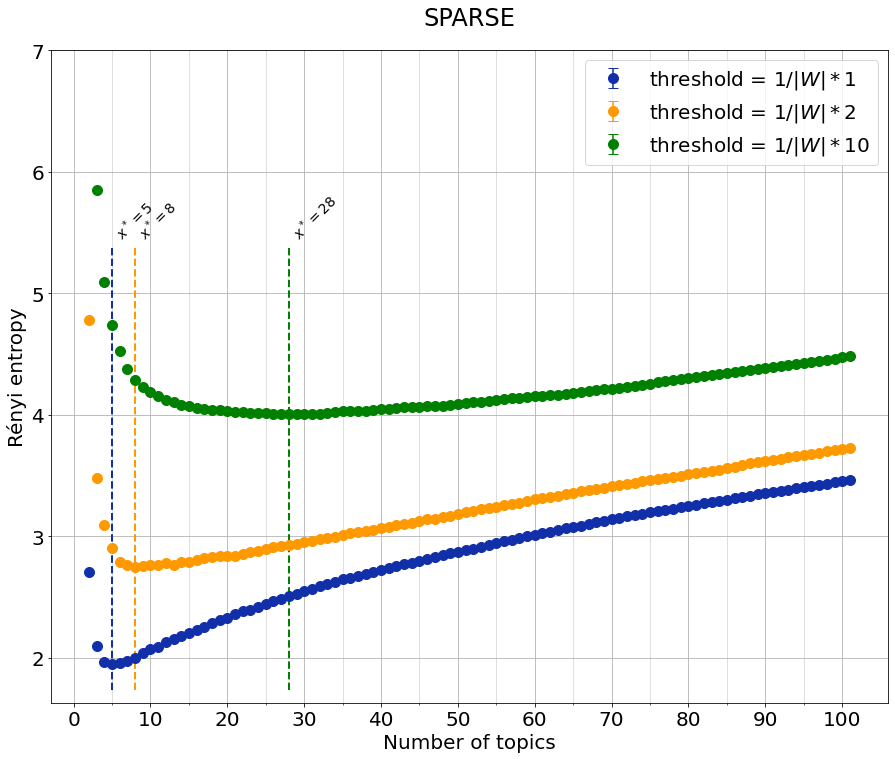

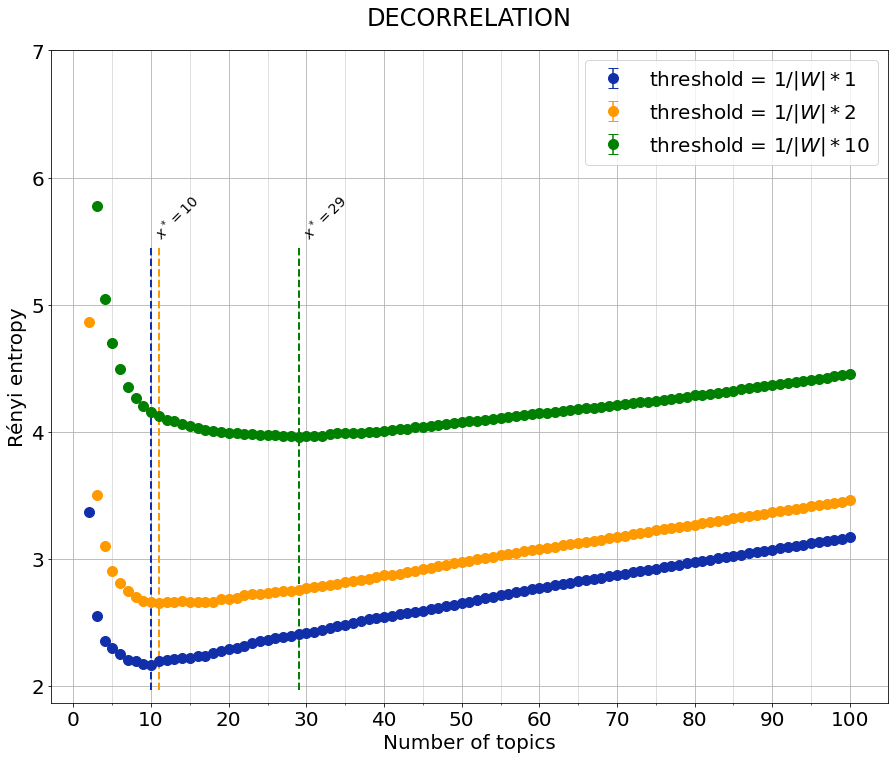

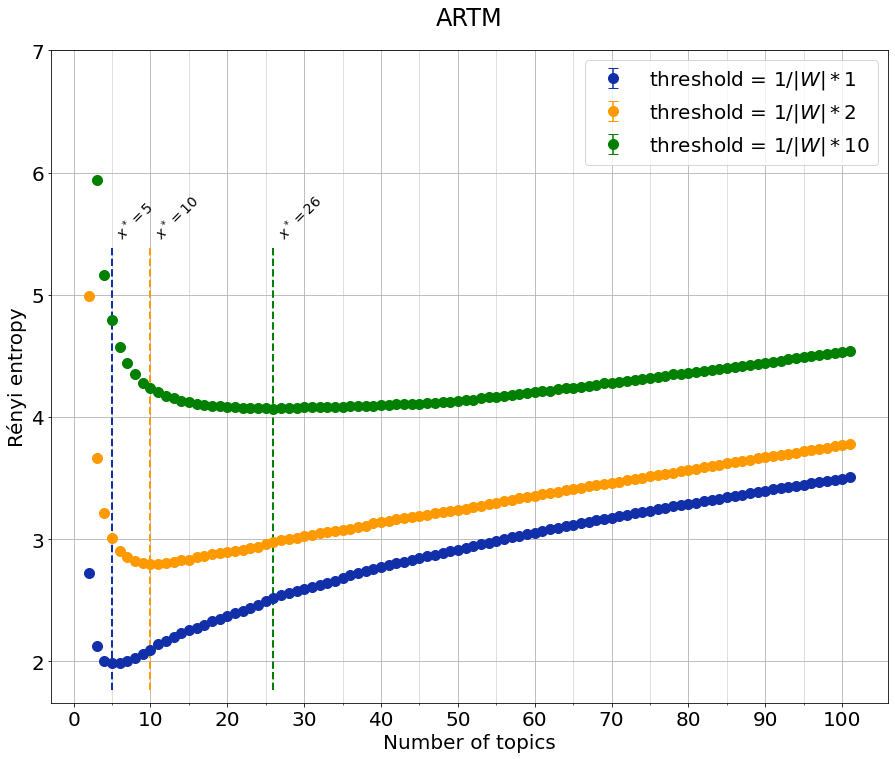

In [ ]:
draw_all_plots(DATASET_NAME_REUTERS)

First of all, the dataset has $90$ topics, but it is highly unbalanced: only $21$ topics has $100$ or more documents associated with them, and only $5$ topics has $500$ or more documents.

There is no such model which managed to find a number of topics close to $90$.
However, `ARTM` and `SPARSE` gave $5$ as an answer (for `threshold = 1`), and other models gave $\sim 10$.

`threshold = 10` gave almost the same number of topics $28$ for all models.

### WikiRef220<a id="wikiref"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

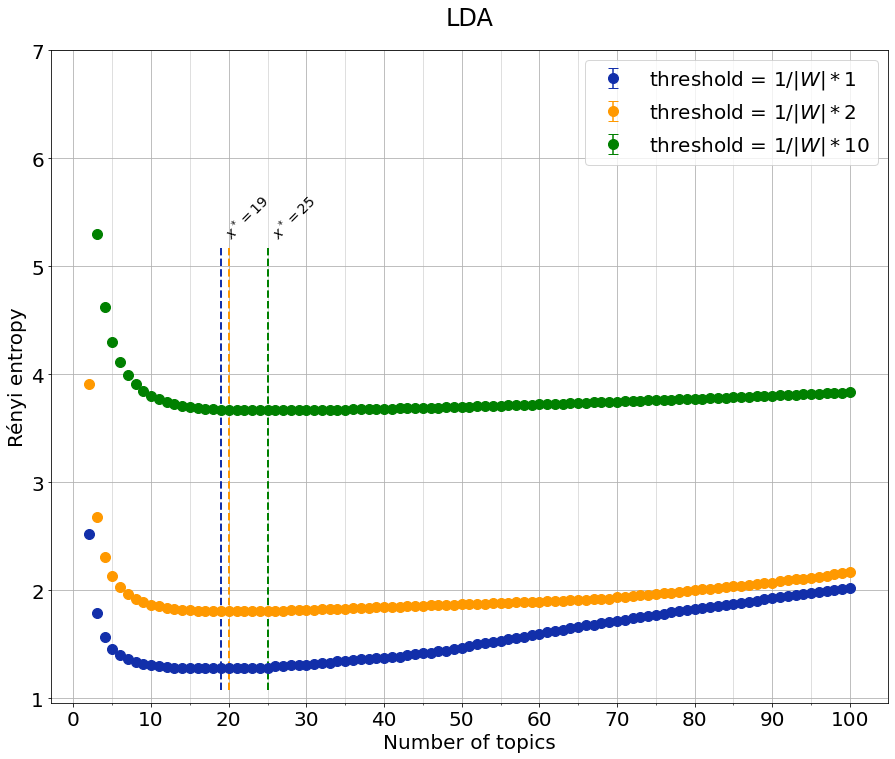

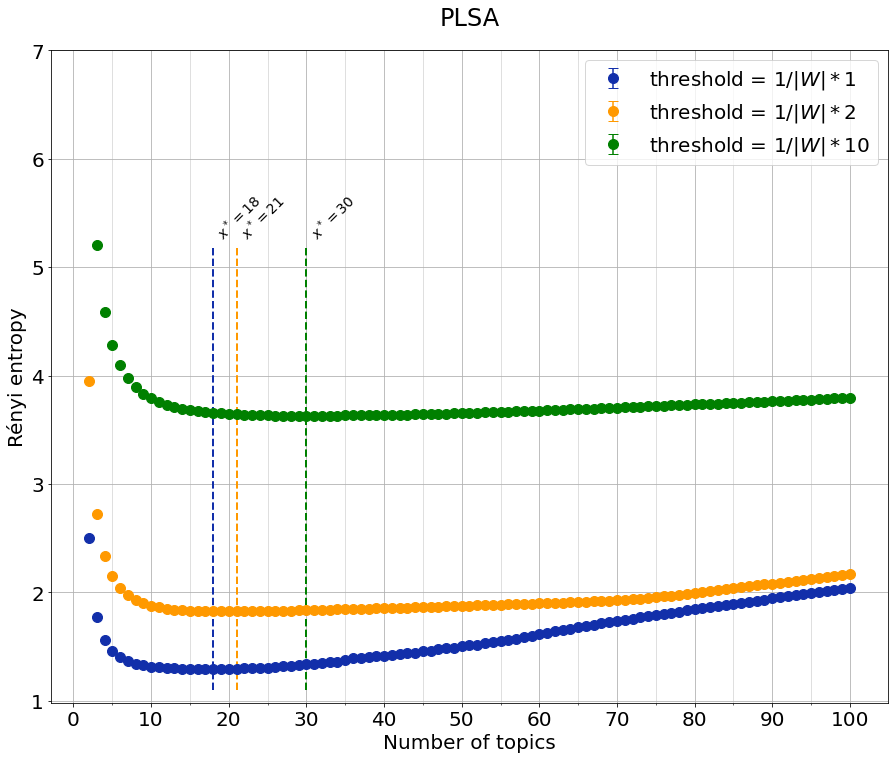

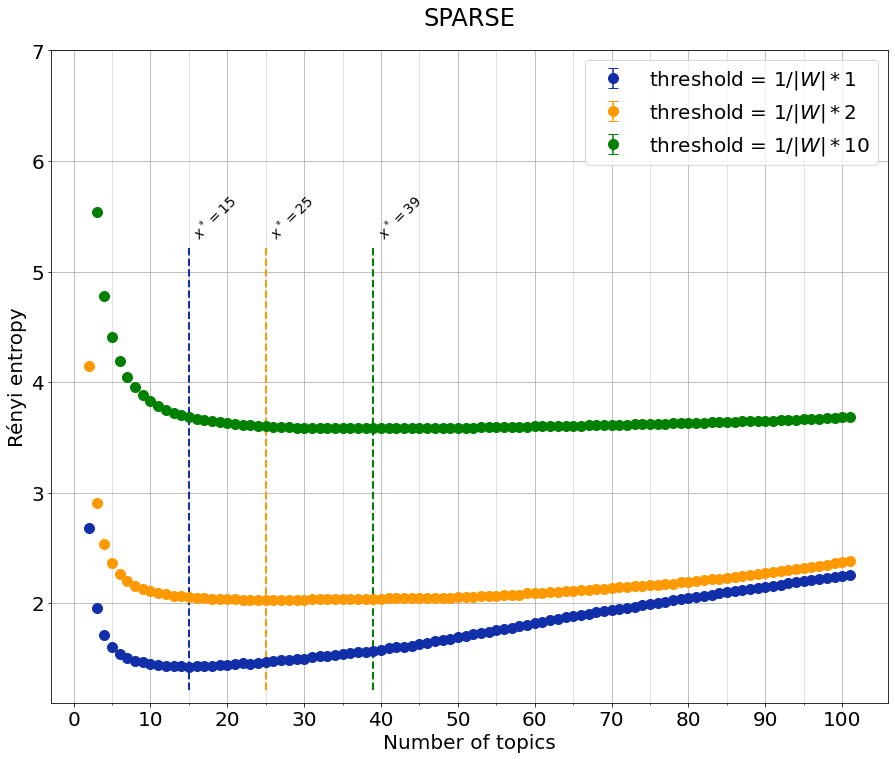

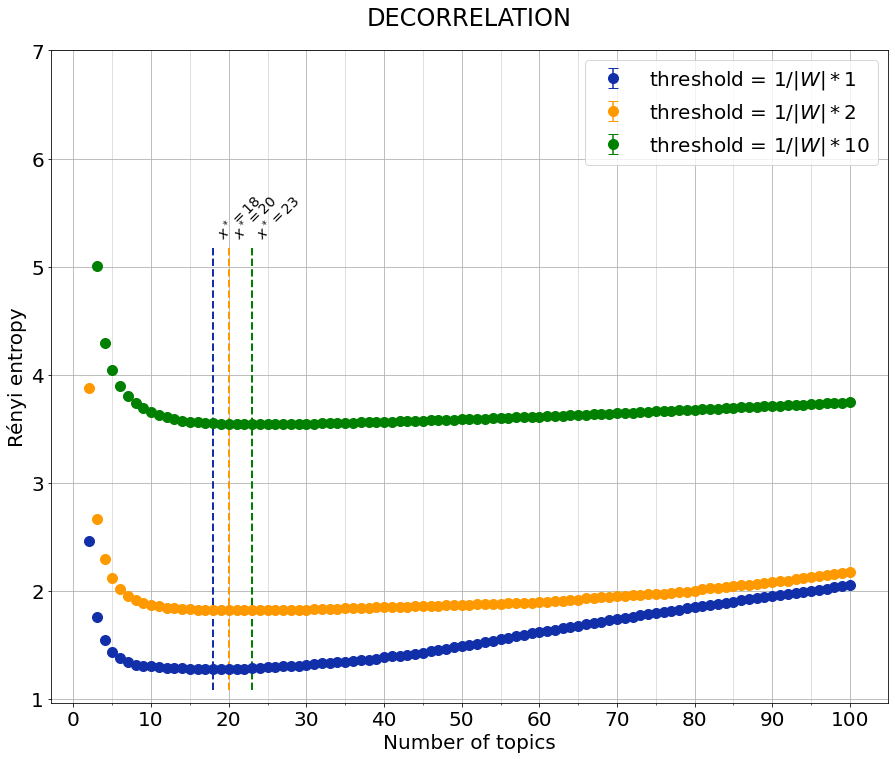

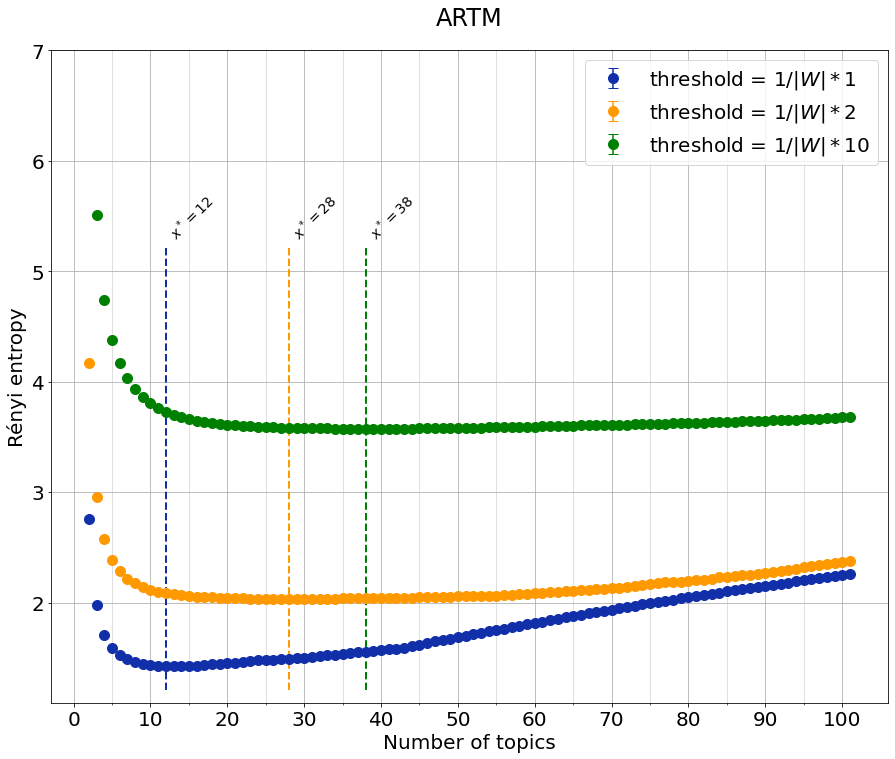

In [ ]:
draw_all_plots(DATASET_NAME_WIKIREF)

Again, `SPARSE` and `ARTM` show fewer number of topics than other models.
`LDA`, `PLSA` and `DECORRELATION` are almost the same: $\sim 19$ topics.

### Good RU Wiki<a id="good-ru-wiki"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

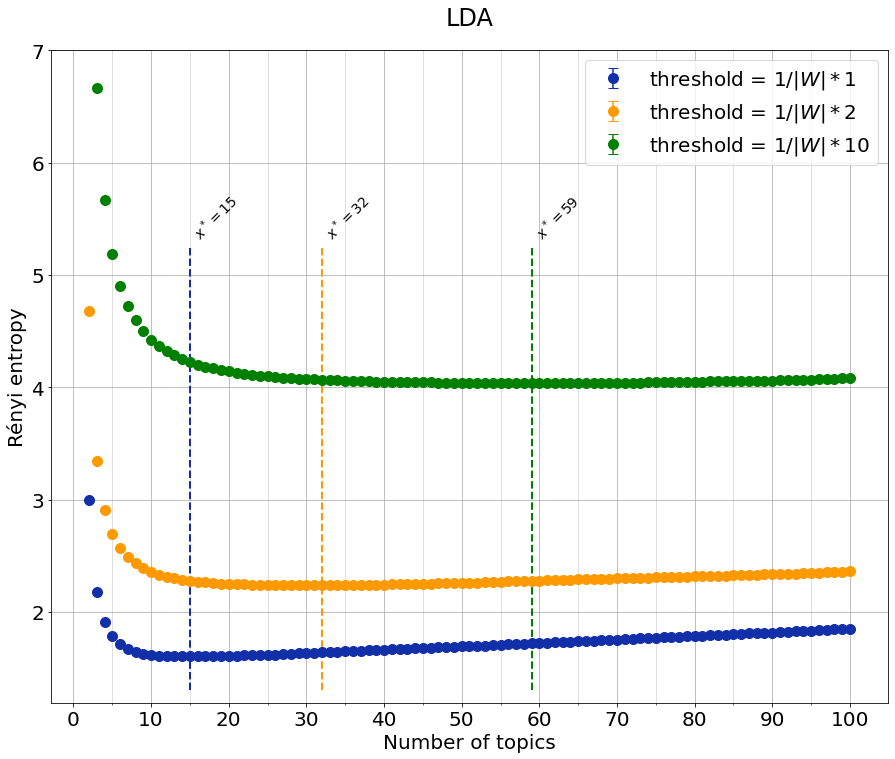

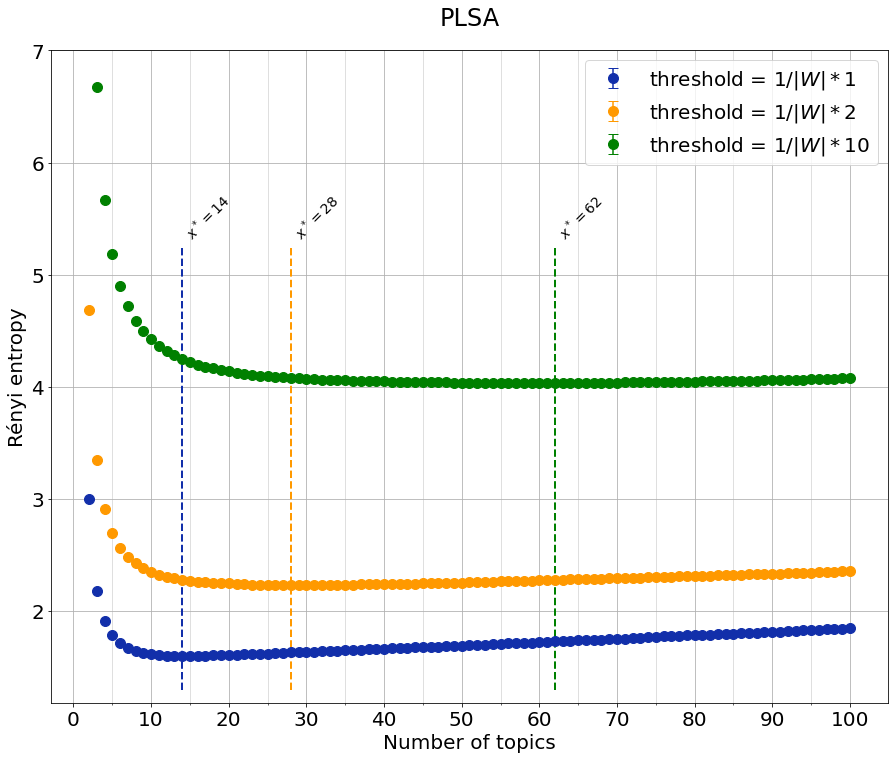

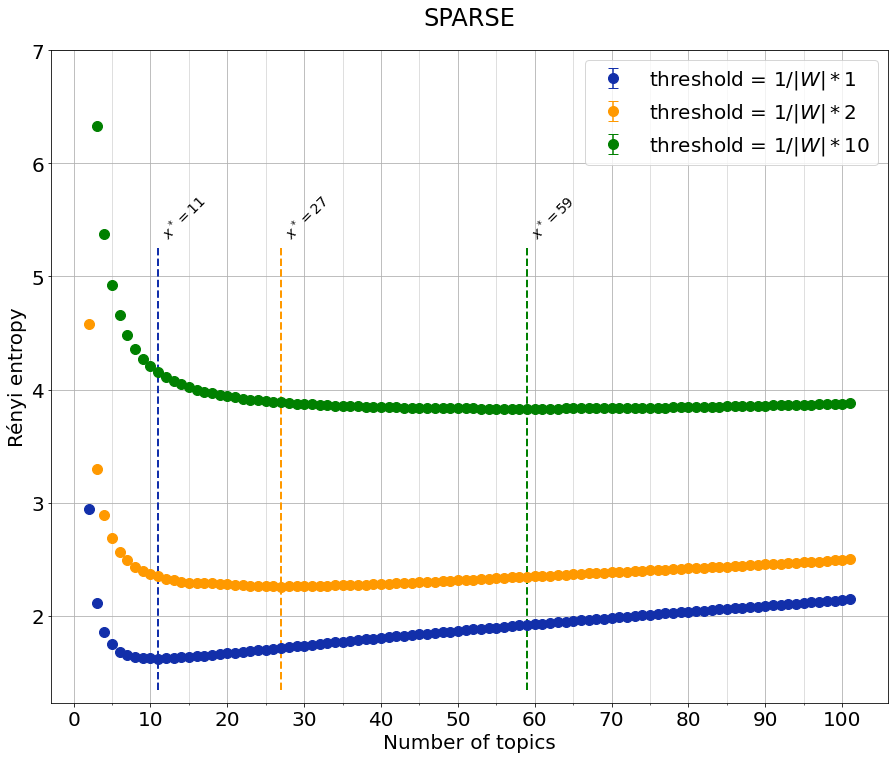

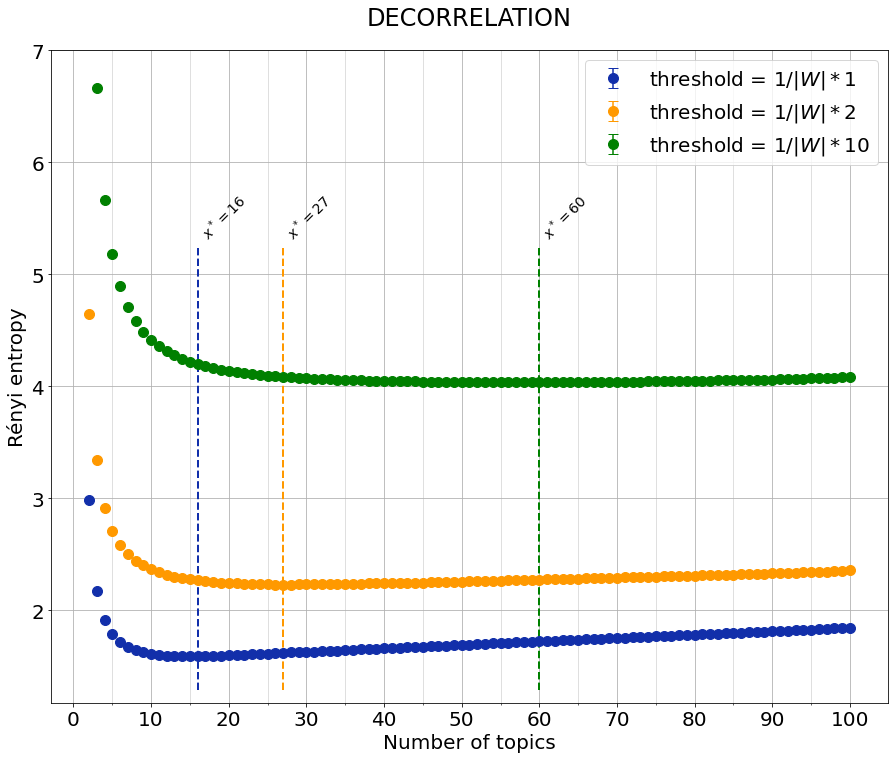

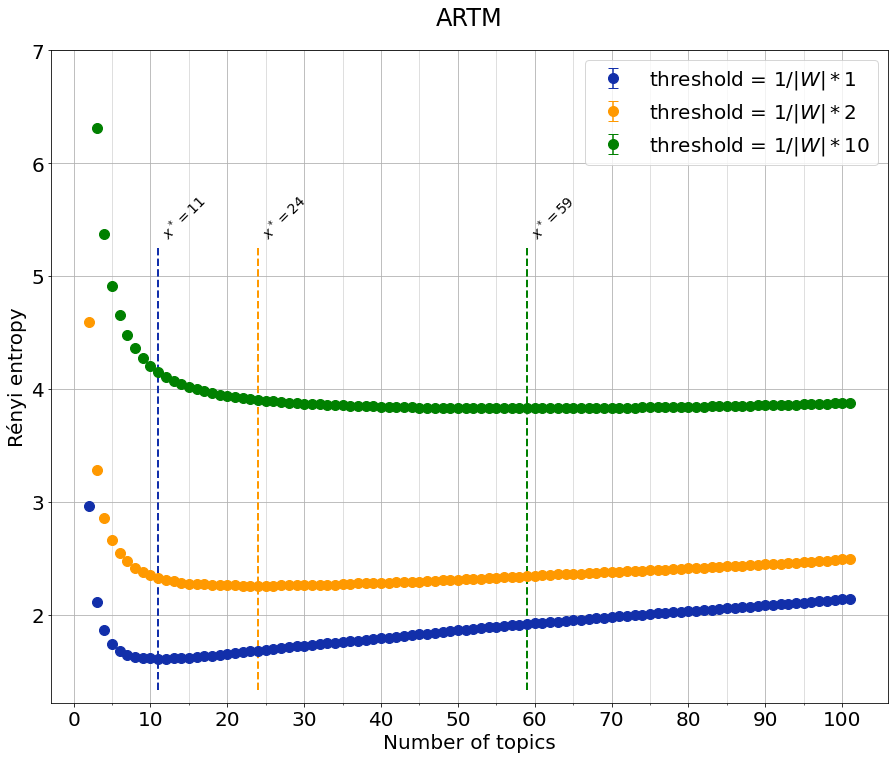

In [ ]:
draw_all_plots(DATASET_NAME_GOOD_RU_WIKI)

`PLSA`, `LDA` and `DECORRELATION` gave $\sim 15$.
`SPARSE` and `ARTM` — $\sim 11$.

Worth noting that `threshold = 10` let all models to give the same result: number of topics equal to $60$.
The relative difference in answers is also low for `threshold = 2` ($27$ topics)

---



So, some interesting points may be observed:
* Different models may find different numbers of topics.
* Parameter `threshold` plays role: bigger thresholds generally lead to higher optimal number of topics found by search method. Also, big thresholds may lead to same results for different topic models.
* Found optimal numbers of topics was usually far lower than the expected values. This may be due to disbalance in text collections that were studied.